In [1]:
# Импортируем модули
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

import os
# этот блок закомментирован так как используется только на kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
#PATH_to_file = '/kaggle/input/sf-dst-scoring/'

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# Датасет

In [3]:
# Импортируем датасеты
#df_train = pd.read_csv(PATH_to_file+'train.csv')
#df_test = pd.read_csv(PATH_to_file+'test.csv')
#sample_submission = pd.read_csv(PATH_to_file+'sample_submission.csv')

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

В **df_train**: 73799 записей и 19 признаков

В **df_train**: 36349 записей и 18 признаков

В **df_train** отсутствует целевая переменная **default**

In [7]:
# Разделим признаки на группы в зависимости от типа: числовые, категориальные и бинарные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
cat_cols = ['education','sna', 'home_address', 'work_address', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

Остаются целевая переменная default и app_date, который требует дополнительной обработки.

In [8]:
#для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [9]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
14923,33243,09FEB2014,SCH,M,35,N,N,0,1,-2.348511,3,60,1,3,58000,4,1,N,0,NaN
21554,85438,02APR2014,PGR,F,43,N,N,0,0,-1.892329,4,70,2,3,200000,1,3,Y,0,NaN
60055,84491,01APR2014,SCH,F,39,N,N,0,0,-1.831866,1,50,2,3,15000,1,3,N,1,1.0
24625,100333,17APR2014,SCH,M,42,Y,Y,0,0,-2.102715,0,40,1,2,60000,1,3,N,0,NaN
43766,58951,07MAR2014,SCH,F,58,N,N,0,0,-1.284788,0,50,2,3,30000,2,3,N,1,0.0


### Описание полей

- client_id - идентификатор клиента

- education - уровень образования

- sex - пол заемщика

- age - возраст заемщика

- car - флаг наличия автомобиля

- car_type - флаг автомобиля иномарки

- decline_app_cnt - количество отказанных прошлых заявок

- good_work - флаг наличия “хорошей” работы

- bki_request_cnt - количество запросов в БКИ

- home_address - категоризатор домашнего адреса

- work_address - категоризатор рабочего адреса

- income - доход заемщика

- foreign_passport - наличие загранпаспорта

- sna - связь заемщика с клиентами банка

- first_time - давность наличия информации о заемщике

- score_bki - скоринговый балл по данным из БКИ

- region_rating - рейтинг региона

- app_date - дата подачи заявки

- default - флаг дефолта по кредиту

# EDA

## Обработка пропусков

In [10]:
data.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
sample                  0
default             36349
dtype: int64

Пропущенные значения есть только у одного признака - **education**

Предположим, что наличие хорошей работы зависит от уровня образования. Сгруппируем по признаку **good_work** и проверим.

In [11]:
ed_1 = data[data['good_work'] == 1]['education'].value_counts().index[0]
ed_0 = data[data['good_work'] == 0]['education'].value_counts().index[0]
print(f'У признака good_work = 1 чаще всего уровень образования {ed_1}')
print(f'У признака good_work = 0 чаще всего уровень образования {ed_0}')

У признака good_work = 1 чаще всего уровень образования GRD
У признака good_work = 0 чаще всего уровень образования SCH


Заполним отсутствующие значения в признаке education в зависимости от флага наличия хорошей работы.

In [12]:
def fill_education(row):
    if pd.isnull(row['education']):
        if row['good_work'] == 1:
            return ed_1
        if row['good_work'] == 0:
            return ed_0
    return row['education']

data['education'] = data.apply(fill_education, axis = 1)

## Обработка признака app_date

In [13]:
# Посмотрим поближе на признак app_date
data['app_date'].head(3)

0    22MAR2014
1    24JAN2014
2    23MAR2014
Name: app_date, dtype: object

In [14]:
# Это даты подачи заявок на кредит. Приведем его к обрабатываемому формату.
data['app_date'] = pd.to_datetime(data.app_date)

In [15]:
# Выясним даты первой и последней заявок
start = data.app_date.min()
end = data.app_date.max()
print(f'Дата первой заявки {start}')
print(f'Дата последней заявки {end}')

Дата первой заявки 2014-01-01 00:00:00
Дата последней заявки 2014-04-30 00:00:00


In [16]:
# Добавим новый признак - количество дней, прошедших с подачи первой заявки
data['days'] = (data.app_date - start).dt.days.astype('int')

In [17]:
# Добавим этот признак к числовым
num_cols.append('days')

## Целевая переменная

In [18]:
data.default.value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

<AxesSubplot:xlabel='default', ylabel='count'>

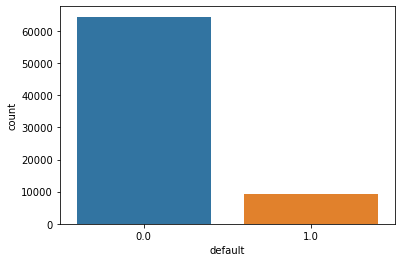

In [19]:
sns.countplot(x='default', data = data)

Количество дефолтных кредитов гораздо меньше, чем возвращенных

## Числовые переменные

In [20]:
data[num_cols].describe()

,age,decline_app_cnt,bki_request_cnt,income,score_bki,region_rating,days
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,39.249410,0.273205,2.005002,41012.648537,-1.904535,56.751189,60.971466
std,11.518063,0.799099,2.266926,45399.735051,0.499397,13.065923,32.076078
min,21.000000,0.000000,0.000000,1000.000000,-3.624586,20.000000,0.000000
25%,30.000000,0.000000,0.000000,20000.000000,-2.260434,50.000000,33.000000
50%,37.000000,0.000000,1.000000,30000.000000,-1.920823,50.000000,62.000000
75%,48.000000,0.000000,3.000000,48000.000000,-1.567888,60.000000,89.000000
max,72.000000,33.000000,53.000000,1000000.000000,0.199773,80.000000,119.000000


### Распределение

In [21]:
num_cols = ['age', 'days', 'income', 'region_rating', 'score_bki', 'bki_request_cnt', 'decline_app_cnt']

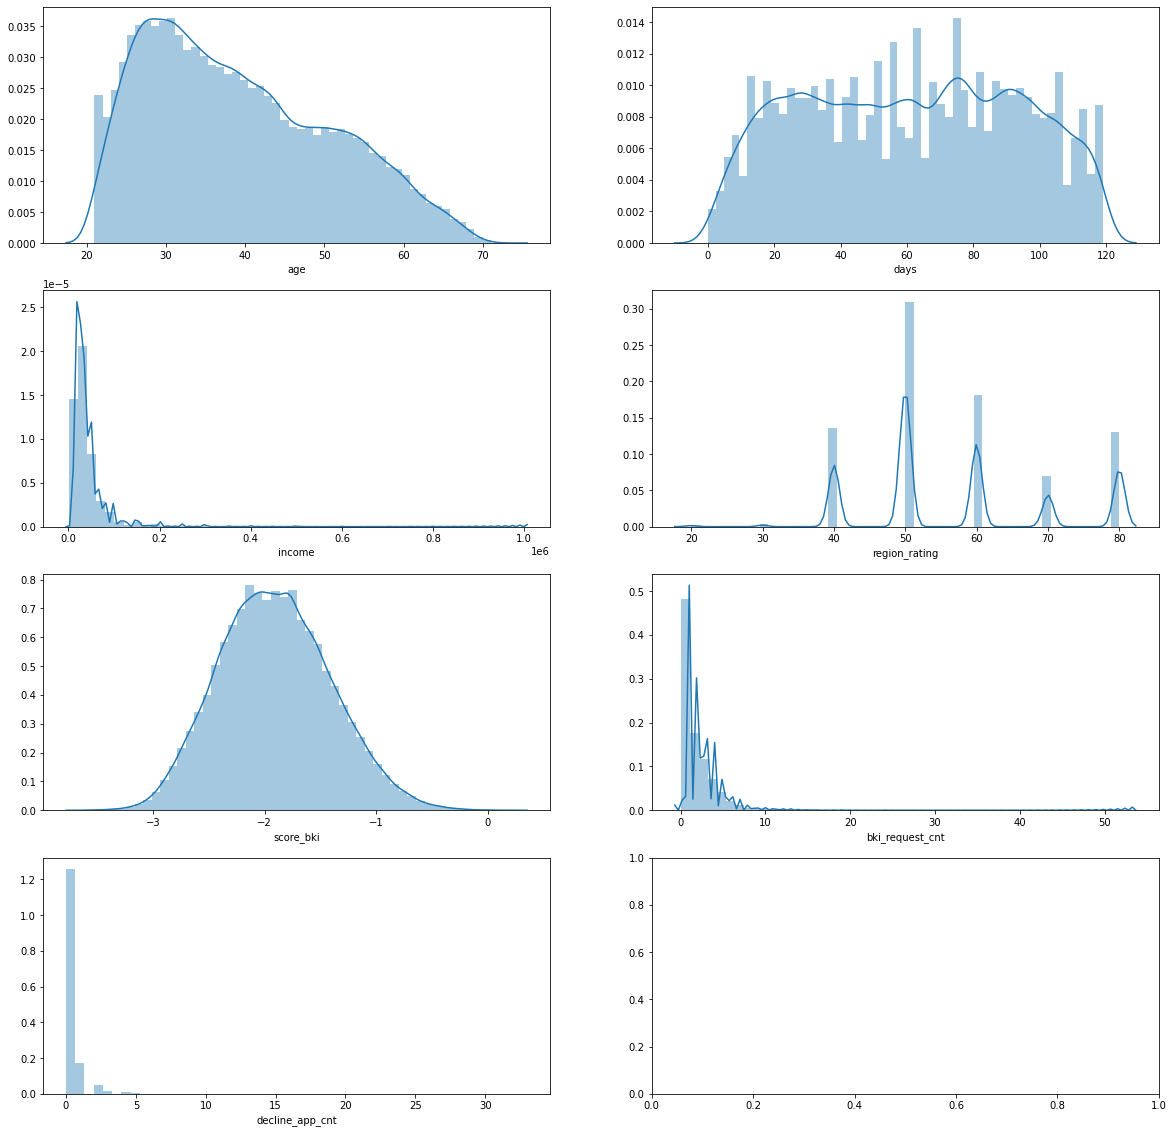

In [22]:
fig, axes = plt.subplots(4, 2, figsize=(20,20))
for column, i in zip(num_cols, range(len(num_cols))):
    sns.distplot(data[column], ax=axes.flat[i])

У всех признаков, кроме **score_bki** распределение неравномерное с тяжелым правым хвостом.

Прологарифмируем неравномерно распределённые признаки и посмотрим как изменится распределение.

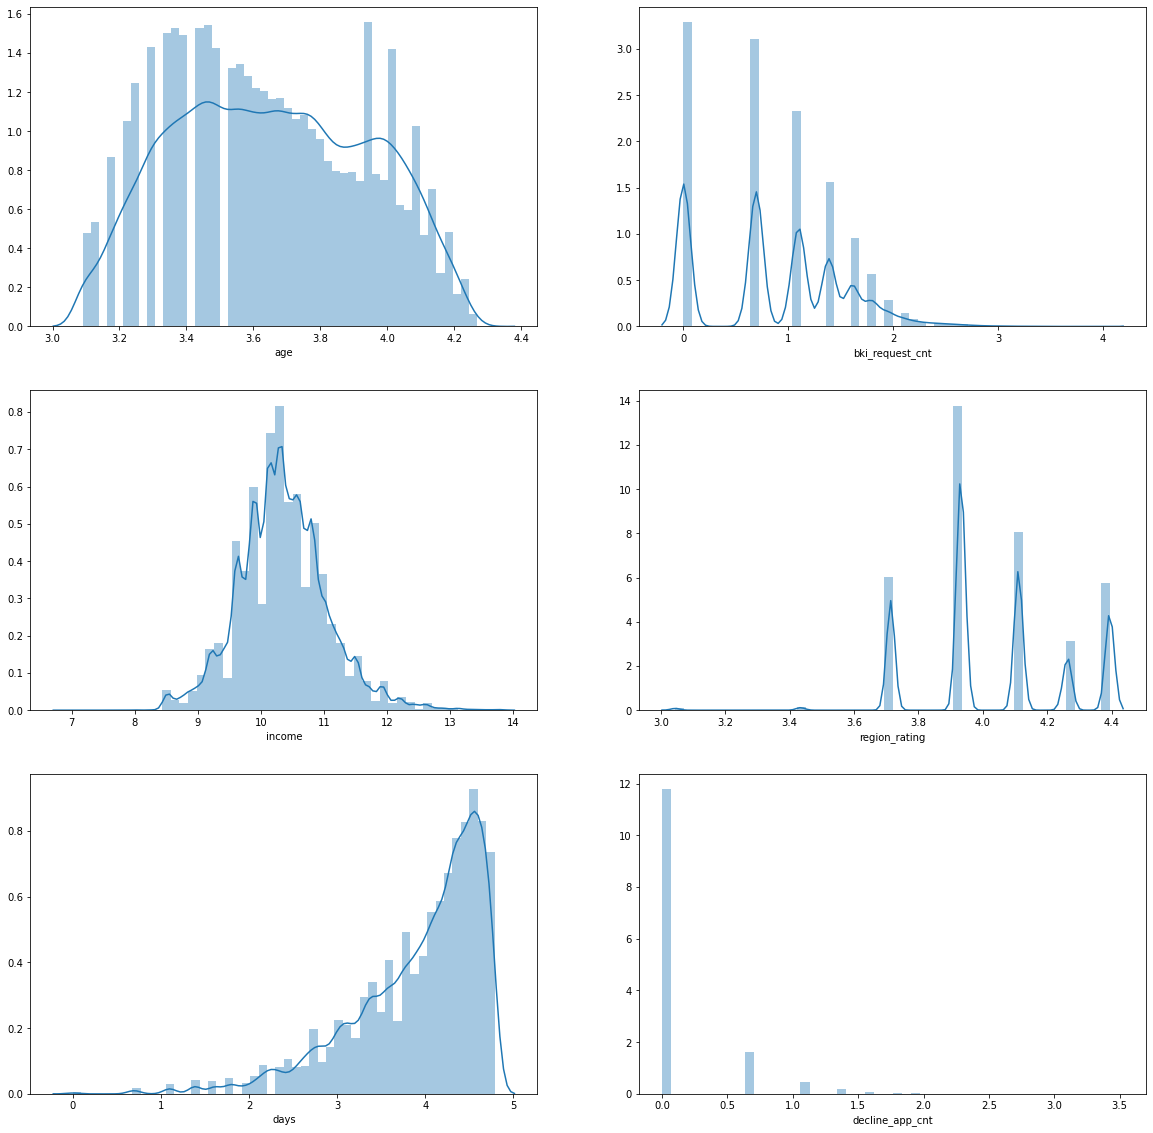

In [23]:
num_cols_log = ['age','bki_request_cnt','income', 'region_rating','days','decline_app_cnt']
fig, axes = plt.subplots(3, 2, figsize=(20,20))

for column, i in zip(num_cols_log, range(len(num_cols_log))):
    data_log = np.log(data[num_cols_log[i]][data[num_cols_log[i]] >= 0] + 1)
    sns.distplot(data_log, ax=axes.flat[i])

Судя по измененным графикам, логарифмирование следующих переменных может помочь при построении модели: 
- 'age',
- 'decline_app_cnt',
- 'bki_request_cnt',
- 'income'

In [24]:
# составим список признаков для логарифмирования
num_cols_log_fin = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

### Выбросы

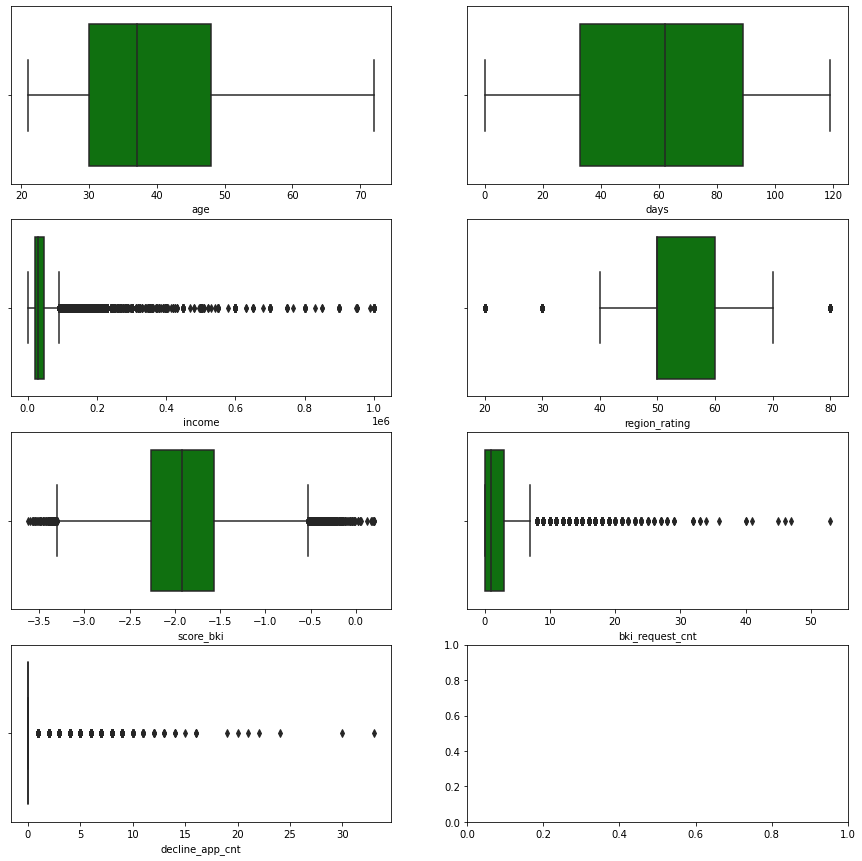

In [25]:
fig, axes = plt.subplots(4, 2, figsize=(15,15))
for column, i in zip(num_cols, range(len(num_cols))):
    sns.boxplot(data[column], ax=axes.flat[i],color='green')

Судя по боксплотам у всех признаков, кроме **age** и **days** очень много выбросов.
Используем межквартильное расстояние (IQR) для определения количества выбросов.

In [26]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return len(np.where((ys > upper_bound) | (ys < lower_bound))[0])

In [27]:
for column in num_cols:
    x = outliers_iqr(data[column])
    print(f'Количество выбросов у признака {column} = {x}')

Количество выбросов у признака age = 0
Количество выбросов у признака days = 0
Количество выбросов у признака income = 7000
Количество выбросов у признака region_rating = 17917
Количество выбросов у признака score_bki = 518
Количество выбросов у признака bki_request_cnt = 2636
Количество выбросов у признака decline_app_cnt = 18677


Выбросов довольно много. Посмотрим, что получится на логарифмируемых значениях переменных.

In [28]:
for column, i in zip(num_cols_log_fin, range(len(num_cols_log_fin))):
    data_log = np.log(data[num_cols_log_fin[i]][data[num_cols_log_fin[i]] >= 0] + 1)
    x = outliers_iqr(data_log)
    print(f'Количество выбросов у признака {column} = {x}')

Количество выбросов у признака age = 0
Количество выбросов у признака decline_app_cnt = 18677
Количество выбросов у признака bki_request_cnt = 15
Количество выбросов у признака income = 2609


Количество выбросов после логарифмирования у признака **decline_app_cnt** не уменьшилось, что объясняется большим количеством нолей. Но это и не выбросы, т.к. вполне логично, что не так уж много заявок отклоняется. Количество выбросов у признаков **bki_request_cnt** и **income** уменьшилось, можно будет при построении удалить эти выбросы и посмотреть на результат.

### Оценка корреляции

<AxesSubplot:>

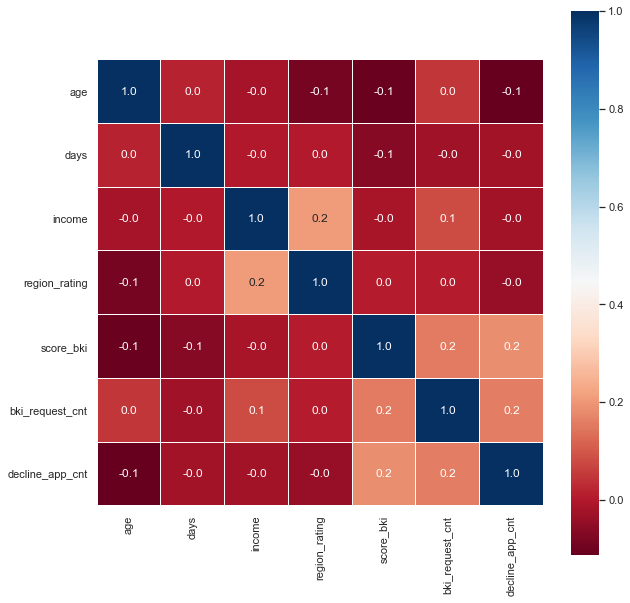

In [29]:
sns.set(font_scale=1)
plt.subplots(figsize=(10, 10))
sns.heatmap(data[num_cols].corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")


Коэффициент корреляции между признаками по модулю не превышает 0.2. Значит необходимости в удалении признаков нет.

## Бинарные переменные

In [30]:
data[bin_cols].describe(include=[object])

,sex,car,car_type,foreign_passport
count,110148,110148,110148,110148
unique,2,2,2,2
top,F,N,N,N
freq,61836,74290,89140,93721


In [31]:
data['good_work'].astype('object').describe(include=[object])

count     110148
unique         2
top            0
freq       91917
Name: good_work, dtype: int64

### Распределение бинарных переменных.

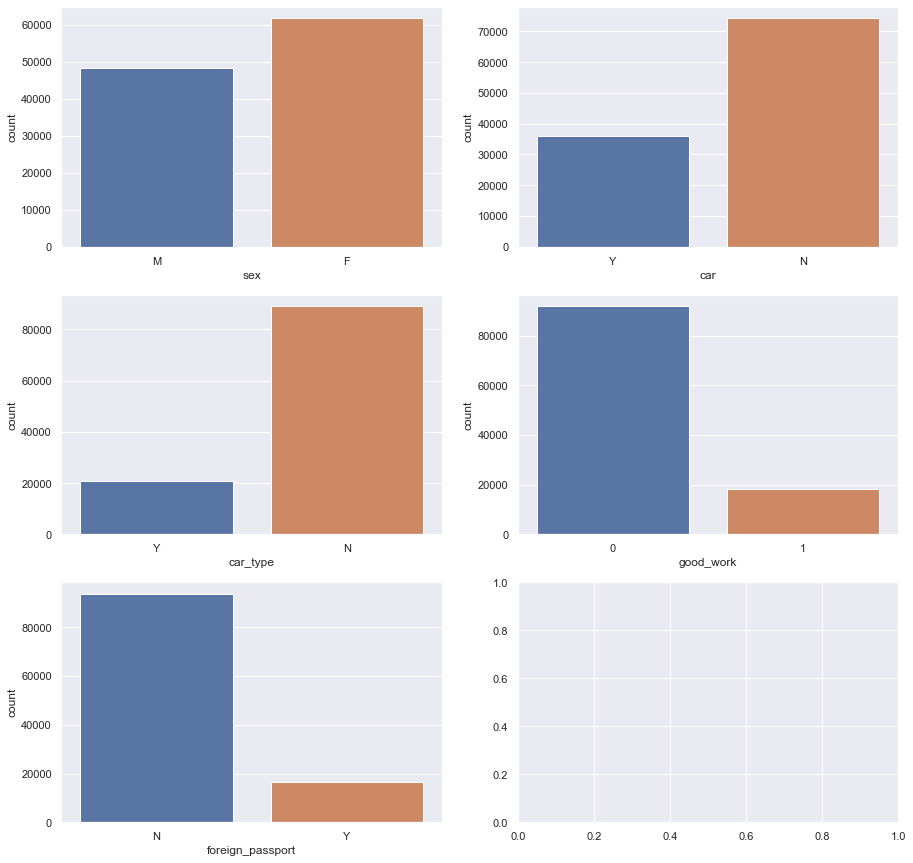

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
for column, i in zip(bin_cols, range(len(bin_cols))):
    sns.countplot(data[column], ax=axes.flat[i])

Самая маленькая пропорция по отношению ко всем заемщикам у тех, у кого нет загран. паспорта. Также невелико количество тех, у кого хорошая работа. Количество тех у кого нет автомобиля примерно вдвое превышает тех, у кого он есть. Большинство автомобилей - российского производства. Количество мужчин немногим меньше количества женщин.

In [33]:
# Преобразуем каждое значение бинарных признаков в уникальное число.
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

## Категориальные переменные

In [34]:
data[cat_cols].astype('object').describe(include=[object])

,education,sna,home_address,work_address,first_time
count,110148,110148,110148,110148,110148
unique,5,4,3,3,4
top,SCH,1,2,3,3
freq,58408,70681,59591,67113,46588


### Распределение категориальных переменных

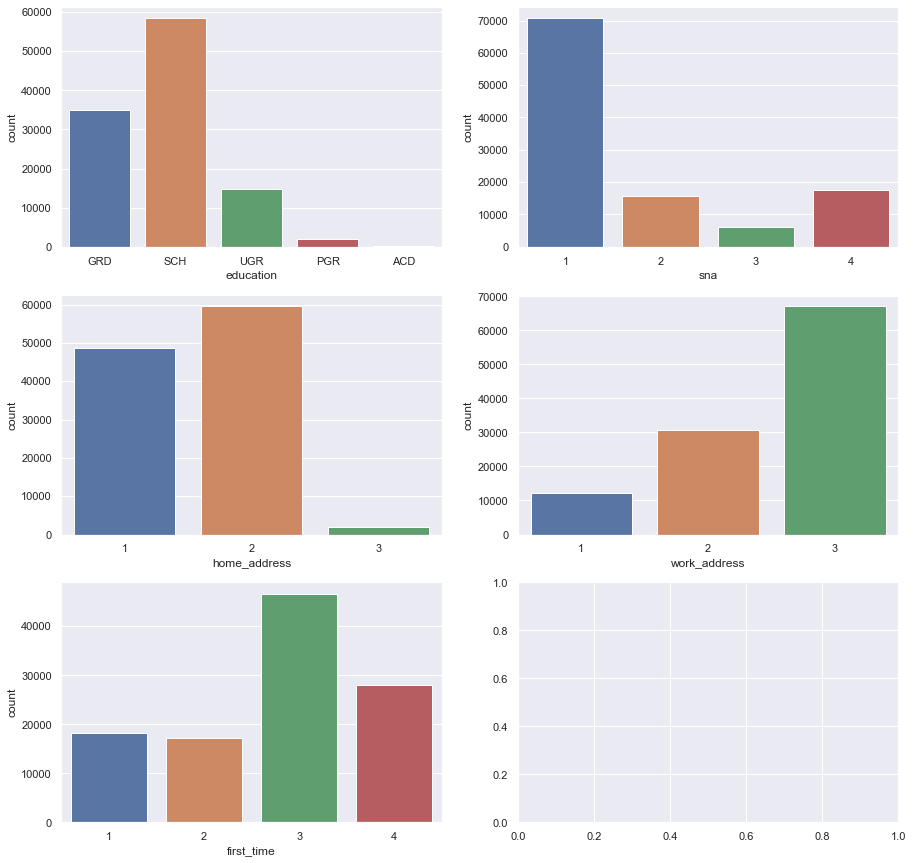

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
for column, i in zip(cat_cols, range(len(cat_cols))):
    sns.countplot(data[column], ax=axes.flat[i])

Значения распределены неравномерно. Либо одна из категорий значительно меньше, либо значительно больше других.

Наиболее часто встречающийся уровень образования - SCH.

Больше всего заёмщиков по признаку связи с клиентами банка относится к категории 1.

Больше всего заёмщиков работает в районе, отнесенного к категории - 3, а живет во 2 и затем 1. 

Больше всего заемщиков, давность наличия информации о которых относится к категории 3.

In [36]:
# Преобразуем каждое значение признака education в уникальное число.
data['education'] = label_encoder.fit_transform(data['education'])

## Значимость признаков

### Значимость числовых признаков

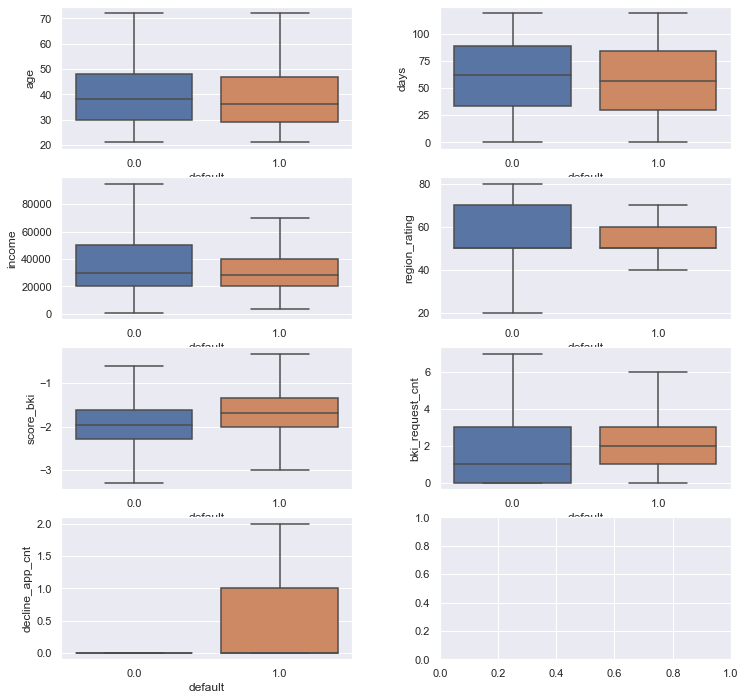

In [37]:
fig, axes = plt.subplots(4, 2, figsize = (12,12)) # subplots(2,2) означает кол-во графиков по горизонтали и кол-во по вертикали
plt.subplots_adjust(wspace = 0.3) # регулирует расстояние между графиками по горизонтали
axes = axes.flatten() #без этого появятся пустые ячейки без графиков
for i in range(len(num_cols)):
    sns.boxplot(x = 'default', y=num_cols[i], data = data[data['sample'] == 1], ax = axes[i], showfliers = False)
    

Судя по боксплотам наименее значимыми признаками являются **days** и **age**

Проверим значимость методом однофакторного дисперсионного анализа (ANOVA)

<AxesSubplot:>

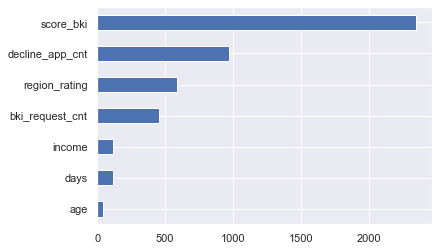

In [38]:
imp_num = Series(f_classif(data[data['sample'] == 1][num_cols], data[data['sample'] == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Предположение подтвердилось. При построении модели можно будет попробовать удалить эти признаки.

### Значимость бинарных и категориальных признаков

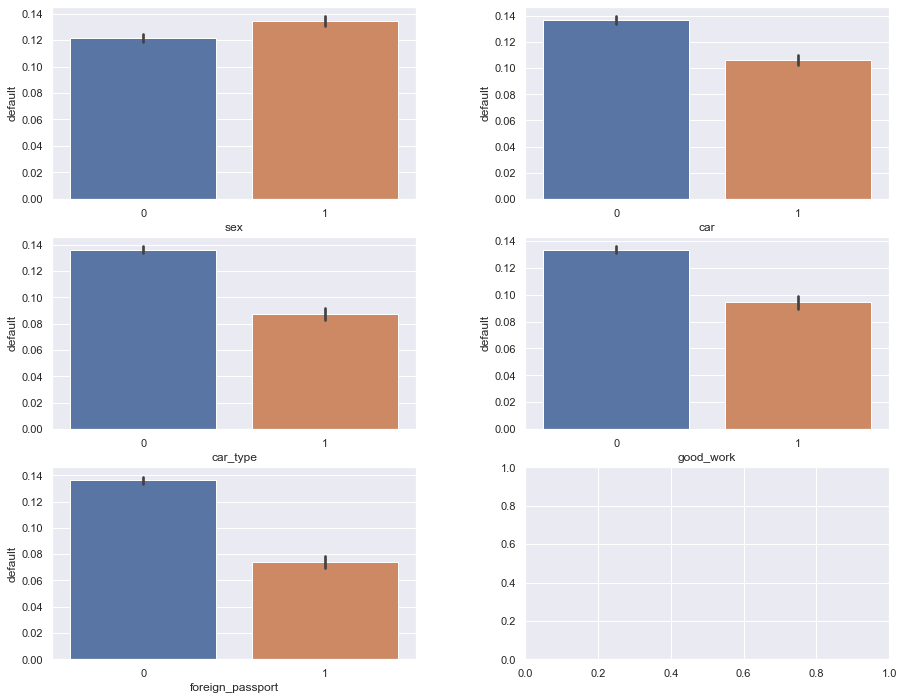

In [39]:
fig, axes = plt.subplots(3, 2, figsize = (15,12)) # subplots(2,2) означает кол-во графиков по горизонтали и кол-во по вертикали
plt.subplots_adjust(wspace = 0.3) # регулирует расстояние между графиками по горизонтали
axes = axes.flatten() #без этого появятся пустые ячейки без графиков
for i in range(len(bin_cols)):
    sns.barplot(y = 'default', x=bin_cols[i], data = data[data['sample'] == 1], ax = axes[i])
    

Судя по диаграммам наименее значимые признаки **sex** и **car**

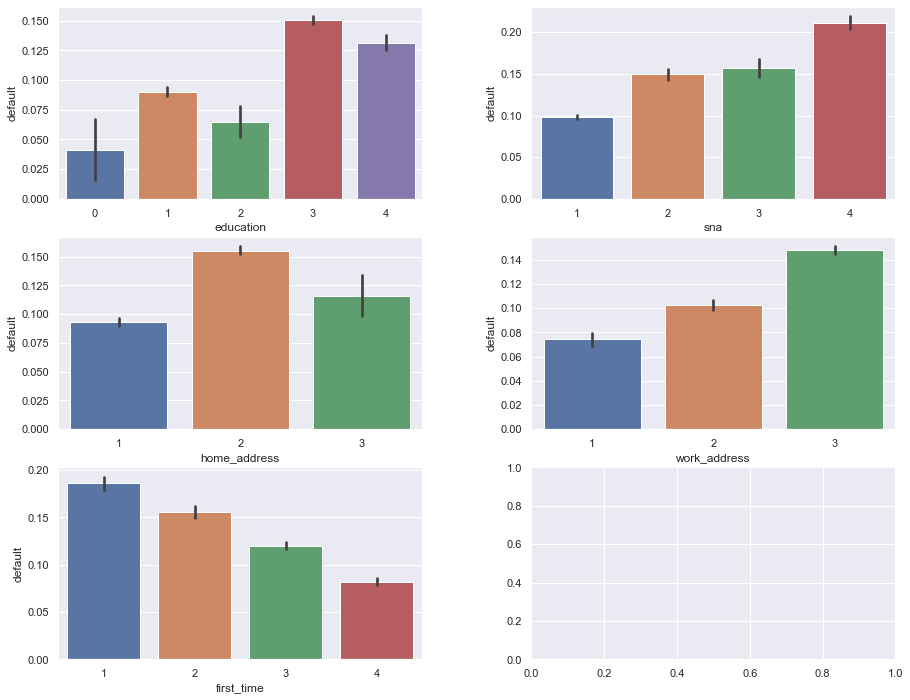

In [40]:
fig, axes = plt.subplots(3, 2, figsize = (15,12)) # subplots(2,2) означает кол-во графиков по горизонтали и кол-во по вертикали
plt.subplots_adjust(wspace = 0.3) # регулирует расстояние между графиками по горизонтали
axes = axes.flatten() #без этого появятся пустые ячейки без графиков
for i in range(len(cat_cols)):
    sns.barplot(y = 'default', x=cat_cols[i], data = data[data['sample'] == 1], ax = axes[i])
    

Среди категориальных по диаграммам сложно выявить наимение важные признаки.
Используем непараметрические методы, основанные на оценке энтропии в группах категориальных переменных для определения значимости признаков.

<AxesSubplot:>

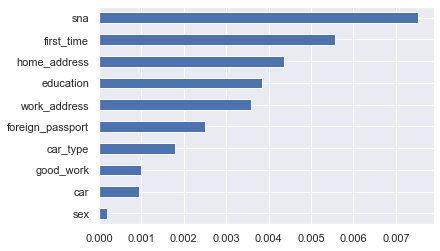

In [41]:
imp_cat = Series(mutual_info_classif(data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наиболее важный признак - **sna**, наименее - **sex**

# Подготовка датасета

In [42]:
#применим dummi- кодирование для категориальных переменных.
data = pd.get_dummies(data, columns=cat_cols)

In [43]:
#логарифмируем отобранные ранее числовые признаки.
for column in num_cols_log_fin:
    data[column] = np.log(data[column] + 1)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   sex               110148 non-null  int64         
 3   age               110148 non-null  float64       
 4   car               110148 non-null  int64         
 5   car_type          110148 non-null  int64         
 6   decline_app_cnt   110148 non-null  float64       
 7   good_work         110148 non-null  int64         
 8   score_bki         110148 non-null  float64       
 9   bki_request_cnt   110148 non-null  float64       
 10  region_rating     110148 non-null  int64         
 11  income            110148 non-null  float64       
 12  foreign_passport  110148 non-null  int64         
 13  sample            110148 non-null  int64         
 14  defa

In [45]:
# Теперь выделим обратно тестовую часть и удалим ненужные признаки.
train_data = data.query('sample == 1').drop(['sample', 'client_id', 'app_date'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id', 'app_date', 'default'], axis=1)

y = train_data.default.values            # выделим таргет

### Полиномиальные признаки

In [46]:
# Применим функцию получения полиномиальных признаков второго рода к обоим датасетам.
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(2)
poly = pf.fit_transform(train_data[['age','decline_app_cnt','bki_request_cnt','income','score_bki','region_rating','days']])[:, 1:]
poly_test = pf.fit_transform(test_data[['age','decline_app_cnt','bki_request_cnt','income','score_bki','region_rating','days']])[:, 1:]

In [47]:
#Стандартизируем полиномиальные призаки в обоих датасетах
scaler = StandardScaler()
poly_st = scaler.fit_transform(poly)
poly_test_st = scaler.fit_transform(poly_test)

In [48]:
# Составим матрицу признаков, удалив признаки к которым была применена полиномиальная функция
X = train_data.drop(['default','age','decline_app_cnt','bki_request_cnt','income','score_bki','region_rating','days'], axis=1)

In [49]:
# Составим единую матрицу признаков
X = np.hstack([X, poly_st])

In [50]:
# Воспользуемся функцией train_test_split для разбиения данных на обучающую и валидационную выборки
# выделим 20% данных на валидацию
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [51]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

((36349, 31), (73799, 32), (73799, 59), (59039, 59), (14760, 59))

# Модель

In [52]:
# создаем модель, используем class_weight= 'balanced', чтобы сбалансировать классы
model = LogisticRegression(class_weight= 'balanced',random_state=RANDOM_SEED)
# обучаем модель
model.fit(X_train, y_train)
# предсказываем значения
y_pred_proba = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

### Метрики

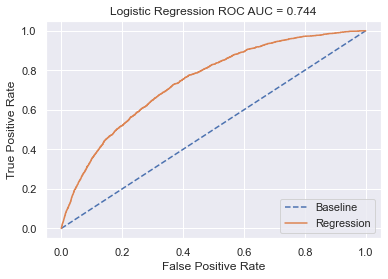

In [53]:
# Посчитаем метрику ROC AUC и построим кривую
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()


In [54]:
# Посмотрим на confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(f'TP = {tp}, FP = {fp}')
print(f'FN = {fn}, TN = {tn}')

TP = 1254, FP = 4308
FN = 573, TN = 8625


На данной модели значение ROC AUC - максимальное. Удаление выбросов и малозначимых признаков приводили только к уменьшению значения метрики.

# Регуляризация

Применим поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией. 

In [55]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print(best_model.best_estimator_.get_params())

{'C': 1291.5496650148827, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [56]:
# снова обучаем модель и предсказываем значения
model = LogisticRegression(C= 1291.5496650148827, class_weight= 'balanced', penalty= 'l2', random_state= RANDOM_SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
y_pred_proba = model.predict_proba(X_valid)[:,1]

### Финальные метрики

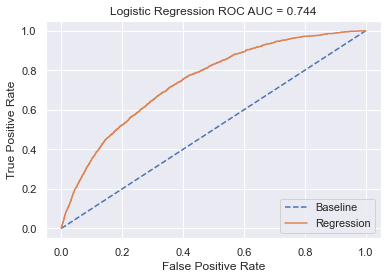

In [57]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [58]:
# Посмотрим на confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(f'TP = {tp}, FP = {fp}')
print(f'FN = {fn}, TN = {tn}')

TP = 1259, FP = 4306
FN = 568, TN = 8627


В итоге с помощью регуляризации ROC AUC улучшить не удалось, но незначительно улучшились значения confusion_matrix

# Submission

In [59]:
test_data = test_data.drop(['age','decline_app_cnt','bki_request_cnt','income','score_bki','region_rating','days'], axis=1)
test_data = np.hstack([test_data, poly_test_st])

In [60]:
predict_submission = model.predict_proba(test_data)[:,1]

In [61]:
submit = pd.DataFrame(df_test.client_id)
submit['default']=predict_submission
submit.to_csv('submission.csv', index=False)

In [62]:
submit.head()

,client_id,default
0,74835,0.220791
1,17527,0.816637
2,75683,0.319559
3,26883,0.376525
4,28862,0.120302
